# 1. Library Import

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator, array_to_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.utils import np_utils

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
from sklearn.metrics import f1_score
from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline

/tmp/ipykernel_28/3973879916.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# 2. Data Preprocessing

In [4]:
MAIN_PATH = '../input/celeba-dataset/'
DATA_PATH = MAIN_PATH + 'img_align_celeba/img_align_celeba/'
ATTRIBUTE_PATH = MAIN_PATH + 'list_attr_celeba.csv'
PARTITION_PATH = MAIN_PATH + 'list_eval_partition.csv'

EXAMPLE_PIC = DATA_PATH + '000001.jpg'
IMG_WIDTH = 178
IMG_HEIGHT = 218

TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 1000
TEST_SAMPLES = 1000

BATCH_SIZE = 16
NUM_EPOCHS = 30
INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

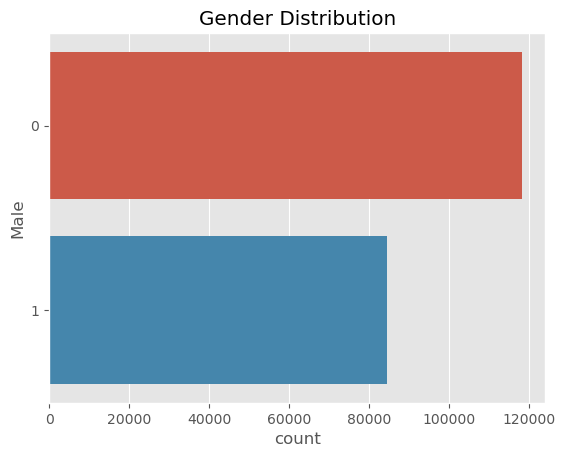

In [5]:
attr_df = pd.read_csv(ATTRIBUTE_PATH, index_col='image_id')
attr_df.replace(to_replace=-1, value=0, inplace=True)

plt.title('Gender Distribution')
sns.countplot(y = 'Male', data=attr_df)
plt.show()

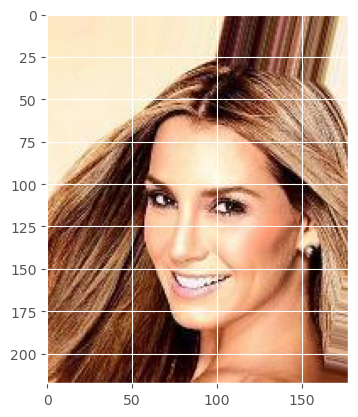

In [6]:
img = load_img(EXAMPLE_PIC)
plt.imshow(img)
plt.show()

In [7]:
parti_df = pd.read_csv(PARTITION_PATH, index_col='image_id')
parti_df.head()

,partition
image_id,
000001.jpg,0
000002.jpg,0
000003.jpg,0
000004.jpg,0
000005.jpg,0


In [8]:
parti_df.value_counts()

partition
0            162770
2             19962
1             19867
dtype: int64

In [9]:
sampling_df = attr_df[['Male']].join(parti_df)
sampling_df.head()

,Male,partition
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,1,0
000004.jpg,0,0
000005.jpg,0,0


# 3. Functions for Data

In [10]:
def load_reshape_img(filename):
    img = load_img(filename)
    img_array = img_to_array(img)/255
    img_array = img_array.reshape((1,) + img_array.shape)
    return img_array

In [11]:
def sampling(partition, sample_size, sampling_df):
    parti_mask = sampling_df['partition'] == partition
    male_mask = sampling_df['Male'] == 1
    female_mask = sampling_df['Male'] == 0
    sampled_df = pd.concat([
        sampling_df[parti_mask & male_mask].sample(sample_size//2),
        sampling_df[parti_mask & female_mask].sample(sample_size//2)
    ])
    
    if partition != 2:
        x = np.array([load_reshape_img(DATA_PATH + filename) for filename in sampled_df.index])
        x = x.reshape(x.shape[0], 218, 178, 3)
        y = np_utils.to_categorical(sampled_df['Male'],2)
    else:
        x = []
        y = []
        for index, target in sampled_df.iterrows():
            im = cv2.imread(DATA_PATH + index) # return BGR
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0 # convert it to RGB for consistency
            im = np.expand_dims(im, axis =0)
            x.append(im)
            y.append(target['Male'])
            
    return x, y

In [12]:
gender_target = {0: 'Female'
                , 1: 'Male'}

def img_to_display(filename):
    
    i = Image.open(filename)
    i.thumbnail((200, 200), Image.LANCZOS)
    
    with BytesIO() as buffer:
        i.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

In [13]:
def display_result(filename, prediction, target):
    
    gender = 'Male'
    gender_icon = "https://i.imgur.com/nxWan2u.png"
        
    if prediction[1] <= 0.5:
        gender_icon = "https://i.imgur.com/oAAb8rd.png"
        gender = 'Female'
            
    display_html = '''
    <div style="overflow: auto;  border: 2px solid #D8D8D8;
        padding: 5px; width: 420px;" >
        <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
        <div style="padding: 10px 0px 0px 20px; overflow: auto;">
            <img src="{}" style="float: left;" width="40" height="40">
            <h3 style="margin-left: 50px; margin-top: 2px;">{}</h3>
            <p style="margin-left: 50px; margin-top: -6px; font-size: 12px">{} prob.</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Real Target: {}</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Filename: {}</p>
        </div>
    </div>
    '''.format(img_to_display(filename)
               , gender_icon
               , gender
               , "{0:.2f}%".format(round(max(prediction)*100,2))
               , gender_target[target]
               , filename.split('/')[-1]
               )

    display(HTML(display_html))

In [14]:
def gender_prediction(filename):
    
    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (178, 218)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    
    result = model.predict(im)
    prediction = np.argmax(result)
    
    return result

In [15]:
x_train, y_train = sampling(0, TRAINING_SAMPLES, sampling_df)
x_valid, y_valid = sampling(1, VALIDATION_SAMPLES, sampling_df)
x_test, y_test = sampling(2, TEST_SAMPLES, sampling_df)

# 4. Preparing the Data for the Model

In [16]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(x_train, y_train,batch_size=BATCH_SIZE)

In [17]:
InceptionV3_model = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
print("number of layers:", len(InceptionV3_model.layers))

87910968/87910968 [==============================] - 3s 0us/step
number of layers: 311


In [18]:
x = InceptionV3_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)

predictions = Dense(2, activation="softmax")(x)

In [19]:
model = Model(inputs=InceptionV3_model.input, outputs=predictions)

for layer in model.layers[:52]:
    layer.trainable = False

In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=0.0001, momentum=0.9), 
              metrics=['accuracy'])

In [21]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [22]:
checkpointer = ModelCheckpoint(filepath='model.h5', 
                               verbose=1, 
                               save_best_only=True)

In [23]:
hist = model.fit(train_generator, 
                 validation_data = (x_valid, y_valid), 
                 steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE, 
                 epochs= NUM_EPOCHS, 
                 callbacks=[checkpointer,callback], 
                 verbose=1)

Epoch 1/30
625/625 [==============================] - ETA: 0s - loss: 0.5137 - accuracy: 0.7355
Epoch 1: val_loss improved from inf to 0.23313, saving model to model.h5
625/625 [==============================] - 124s 161ms/step - loss: 0.5137 - accuracy: 0.7355 - val_loss: 0.2331 - val_accuracy: 0.9120
Epoch 2/30
625/625 [==============================] - ETA: 0s - loss: 0.3215 - accuracy: 0.8647
Epoch 2: val_loss improved from 0.23313 to 0.16750, saving model to model.h5
625/625 [==============================] - 95s 152ms/step - loss: 0.3215 - accuracy: 0.8647 - val_loss: 0.1675 - val_accuracy: 0.9320
Epoch 3/30
625/625 [==============================] - ETA: 0s - loss: 0.2653 - accuracy: 0.8904
Epoch 3: val_loss improved from 0.16750 to 0.14147, saving model to model.h5
625/625 [==============================] - 95s 152ms/step - loss: 0.2653 - accuracy: 0.8904 - val_loss: 0.1415 - val_accuracy: 0.9430
Epoch 4/30
625/625 [==============================] - ETA: 0s - loss: 0.2413 - acc

# 5. Model Success Visualization

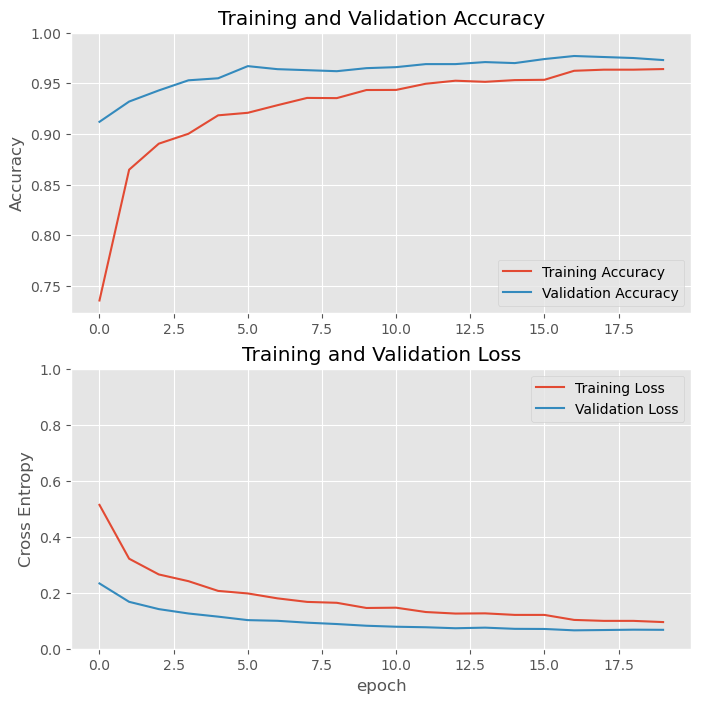

In [24]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [25]:
model.load_weights('model.h5')
predictions = [np.argmax(model.predict(image)) for image in x_test]
accuracy = 100 * np.sum(np.array(predictions)==y_test) / len(predictions)
f1 = f1_score(y_test, predictions)

print('Accuracy: {:.4f}'.format(accuracy))
print('F1 score: {:.4f}'.format(f1))

1/1 [==============================] - 0s 25ms/step
Accuracy: 97.0000
F1 score: 0.9699


In [26]:
model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 176, 216, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 88, 108, 16)      0         
 2D)                                                             
                                                                 
 conv2d_95 (Conv2D)          (None, 86, 106, 32)       4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 43, 53, 32)       0         
 2D)                                                             
                                                                 
 conv2d_96 (Conv2D)          (None, 41, 51, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 20, 25, 64)       0

In [28]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [29]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,
      epochs=15,
      verbose=1)

Epoch 1/15
8/8 [==============================] - 4s 111ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 2/15
8/8 [==============================] - 1s 125ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 3/15
8/8 [==============================] - 2s 204ms/step - loss: 0.6931 - accuracy: 0.5000
Epoch 4/15
8/8 [==============================] - 1s 128ms/step - loss: 0.6931 - accuracy: 0.5000
Epoch 5/15
8/8 [==============================] - 1s 142ms/step - loss: 0.6931 - accuracy: 0.5000
Epoch 6/15
8/8 [==============================] - 1s 122ms/step - loss: 0.6931 - accuracy: 0.5000
Epoch 7/15
8/8 [==============================] - 1s 122ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 8/15
8/8 [==============================] - 1s 127ms/step - loss: 0.6931 - accuracy: 0.5000
Epoch 9/15
8/8 [==============================] - 1s 132ms/step - loss: 0.6931 - accuracy: 0.5000
Epoch 10/15
8/8 [==============================] - 1s 123ms/step - loss: 0.6931 - accuracy: 0.5000
Epoch 11/15
8/8 [==